In [1]:
import pandas as pd
import numpy as np

from eda_utils import *
from features_utils import *

In [2]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [2]:
data = pd.read_parquet('../data/processed/data_ready_featuresengineering.parquet')
data = clean_df(data)

In [3]:
data = Categorize_hours(data,4)

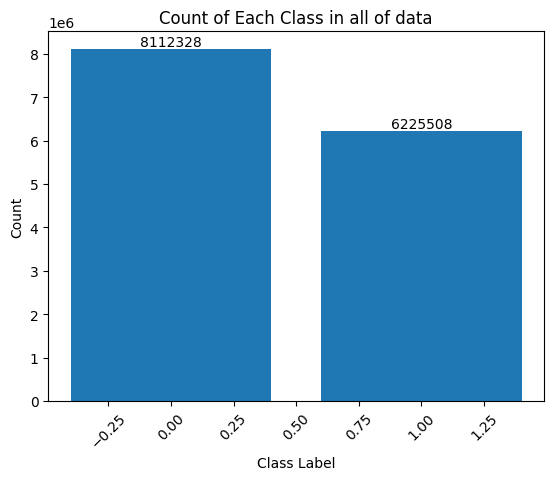

In [4]:
unique_classes, counts = np.unique(data.event, return_counts=True)

# Create a bar plot for each class count within the category
fig, ax = plt.subplots()
ax.bar(unique_classes, counts, label='Counts')

# Add labels and title
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
ax.set_title('Count of Each Class in all of data')

# Show individual values above each bar
for i, v in enumerate(counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

In [5]:
count = 0
array = data.event.copy()
for i in range(len(array)):
    if array[i] == 1:
        count += 1
    elif array[i] == 0 and count != 0:
        array[i-count+1:i] = count
        count = 0

# Handle the case where the sequence of 1s continues until the end of the array
if count != 0:
    for j in range(len(array) - count, len(array)):
        array[j] = count

print(array)

C:\Users\amoha\AppData\Local\Temp\ipykernel_15920\159726762.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '480' has dtype incompatible with uint8, please explicitly cast to a compatible dtype first.
  array[i-count+1:i] = count


0              0
1              0
2              0
3              0
4              0
            ... 
14337831    4703
14337832    4703
14337833    4703
14337834    4703
14337835    4703
Name: event, Length: 14337836, dtype: uint16


In [7]:
threshold = 361
data.event[array < threshold] = 0

C:\Users\amoha\AppData\Local\Temp\ipykernel_15920\1674716498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.event[array < threshold] = 0


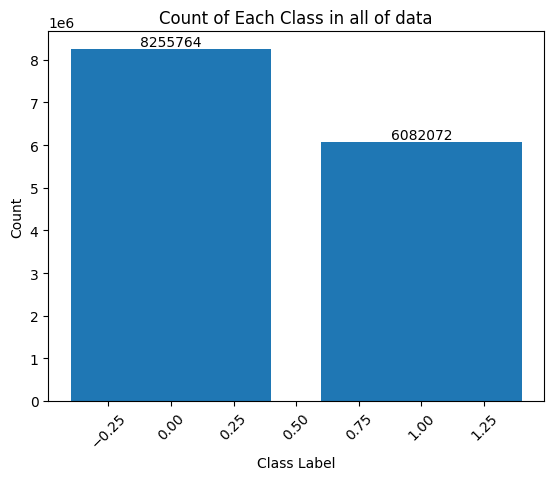

In [8]:
unique_classes, counts = np.unique(data.event, return_counts=True)

# Create a bar plot for each class count within the category
fig, ax = plt.subplots()
ax.bar(unique_classes, counts, label='Counts')

# Add labels and title
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
ax.set_title('Count of Each Class in all of data')

# Show individual values above each bar
for i, v in enumerate(counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

In [16]:
# """
# Replacing sleep duration of below 30 minutes with awake
# """

# threshold = 361
# consecutive_ones = data.event.eq(1).rolling(window=threshold).sum()


# #data.event[consecutive_ones < threshold] = 1

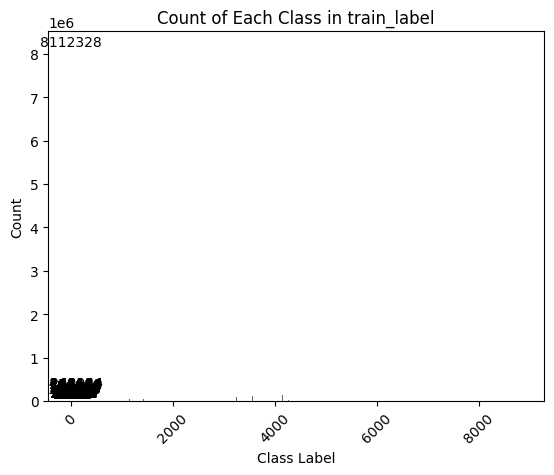

In [9]:
unique_classes, counts = np.unique(array, return_counts=True)

# Create a bar plot for each class count within the category
fig, ax = plt.subplots()
ax.bar(unique_classes, counts, label='Counts')

# Add labels and title
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
ax.set_title('Count of Each Class in train_label')

# Show individual values above each bar
for i, v in enumerate(counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

In [10]:
total_length = len(data)
nu_sections = 4
section_length = total_length // nu_sections
section_length

3584459

In [11]:
test_data = []
train_data = []
val_data = []
test_length = total_length // nu_sections

start_vals = []
end_vals = []
for section in range(nu_sections):
    start_sec = section * test_length
    end_sec = (section + 1) * test_length
    start_vals.append(start_sec)
    end_vals.append(end_sec)

for start, end in zip(start_vals, end_vals):
    train_df_len = int(0.6 * (end - start))
    test_df_len = int(0.2 * (end - start))

    start = int(start)  # Ensure start is an integer

    train_df = data.loc[start:start + train_df_len]
    test_df = data.loc[start + train_df_len:start + train_df_len + test_df_len]
    val_df = data.loc[start + train_df_len + test_df_len:end]

    test_data.append(test_df)
    train_data.append(train_df)
    val_data.append(val_df)
    print(start, start + train_df_len, start + train_df_len + test_df_len, end)


0 2150675 2867566 3584459
3584459 5735134 6452025 7168918
7168918 9319593 10036484 10753377
10753377 12904052 13620943 14337836


## Feature Engineering
    1.  Lag Features : 
    add lag features by adding previous time step values as new features
    
    2.  Rolling and Expanding Windows :
    mean, median, standard deviation, and maximum or minimum values over a moving or progressively larger window of fixed size.

    3.  Exponential Smoothing:
    assigns exponentially decreasing weights to past observations, placing more emphasis on recent observations.
    
    4.  Seasonal Decomposition???

    5. Domain-Specific Features (ANGLE-Z and enmo)

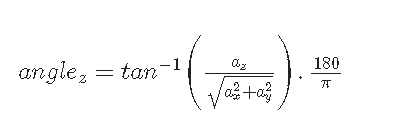

***Z-angle***  : Z-angle, computed using Eq. 3, corresponds to the angle between the accelerometer axis perpendicular to the skin surface and the horizontal plane. As described in “vanHees approach”, any change (or lack of change) in the z-angle over successive time intervals may be an indicator of posture change.

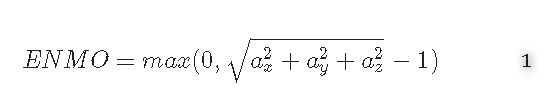

where, ax,ay, and az are median values of the three accelerometer axes computed over a rolling five-second window.

Sleep classification from wrist-worn accelerometer data using random forests: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7794504/#Equ3

feature links (1-4):

https://hackernoon.com/must-know-base-tips-for-feature-engineering-with-time-series-data

https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [12]:
for idx,(test, train, val) in enumerate(zip(test_data, train_data, val_data)):
    train_data[idx] = add_features(train)
    test_data[idx] = add_features(test)
    val_data[idx] = add_features(val)


c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\feature_engineering.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day of year"] = data.timestamp.dt.dayofyear
c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\feature_engineering.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day of week"] = data.timestamp.dt.day_of_week #can also do day_name() for the name of the day
c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\feature_engineering.py:23: SettingWithCopyWarning: 
A value is trying

In [13]:
window_size = 5
for idx,(test, train, val) in enumerate(zip(test_data, train_data, val_data)):
    train_data[idx] = pd.concat([train,Create_lag_features(train,window_size,"enmo","anglez")],axis = 1)
    test_data[idx] = pd.concat([test,Create_lag_features(test,window_size,"enmo","anglez")],axis = 1)
    val_data[idx] = pd.concat([val,Create_lag_features(val,window_size,"enmo","anglez")],axis = 1)


In [14]:
train_all = pd.DataFrame()
test_all = pd.DataFrame()
val_all = pd.DataFrame()
for test, train, val in zip(test_data, train_data, val_data):
    train_all = pd.concat([train_all,train],axis = 0)
    test_all = pd.concat([test_all,test],axis = 0)
    val_all = pd.concat([val_all,val],axis = 0)

In [15]:

train_label = train_all.event
val_label =  val_all.event
test_label =  test_all.event 


test_all = test_all.drop("event",axis = 1)
train_all = train_all.drop("event",axis = 1)
val_all = val_all.drop("event",axis = 1)


In [5]:
test_all

,anglez,enmo,series_id,hour,day_quartile,day of year,day of week,month,days in month,minute,enmo lag_1,enmo lag_2,enmo lag_3,enmo lag_4,enmo lag_5,anglez lag_1,anglez lag_2,anglez lag_3,anglez lag_4,anglez lag_5
2150675,-49.101601,0.0000,33,0,0,7,6,1,31,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2150676,-49.101601,0.0000,33,0,0,7,6,1,31,37,0.0000,NaN,NaN,NaN,NaN,-49.101601,NaN,NaN,NaN,NaN
2150677,-49.101601,0.0000,33,0,0,7,6,1,31,37,0.0000,0.0000,NaN,NaN,NaN,-49.101601,-49.101601,NaN,NaN,NaN
2150678,-49.101601,0.0000,33,0,0,7,6,1,31,37,0.0000,0.0000,0.0000,NaN,NaN,-49.101601,-49.101601,-49.101601,NaN,NaN
2150679,-49.101601,0.0000,33,0,0,7,6,1,31,38,0.0000,0.0000,0.0000,0.0000,NaN,-49.101601,-49.101601,-49.101601,-49.101601,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13620939,26.037600,0.0240,221,18,3,347,2,12,31,1,0.0239,0.0240,0.0239,0.0247,0.0241,26.069401,26.058399,26.052999,25.641001,25.493500
13620940,26.031401,0.0237,221,18,3,347,2,12,31,2,0.0240,0.0239,0.0240,0.0239,0.0247,26.037600,26.069401,26.058399,26.052999,25.641001
13620941,26.043699,0.0242,221,18,3,347,2,12,31,2,0.0237,0.0240,0.0239,0.0240,0.0239,26.031401,26.037600,26.069401,26.058399,26.052999
13620942,26.089199,0.0236,221,18,3,347,2,12,31,2,0.0242,0.0237,0.0240,0.0239,0.0240,26.043699,26.031401,26.037600,26.069401,26.058399


In [13]:
%store train_label
%store val_label
%store test_label

%store test_all
%store train_all
%store val_all

Stored 'train_label' (Series)
Stored 'val_label' (Series)
Stored 'test_label' (Series)
Stored 'test_all' (DataFrame)
Stored 'train_all' (DataFrame)
Stored 'val_all' (DataFrame)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Utils import *
from feature_engineering import *

In [1]:
%store -r train_label
%store -r val_label
%store -r test_label

%store -r test_all
%store -r train_all
%store -r val_all



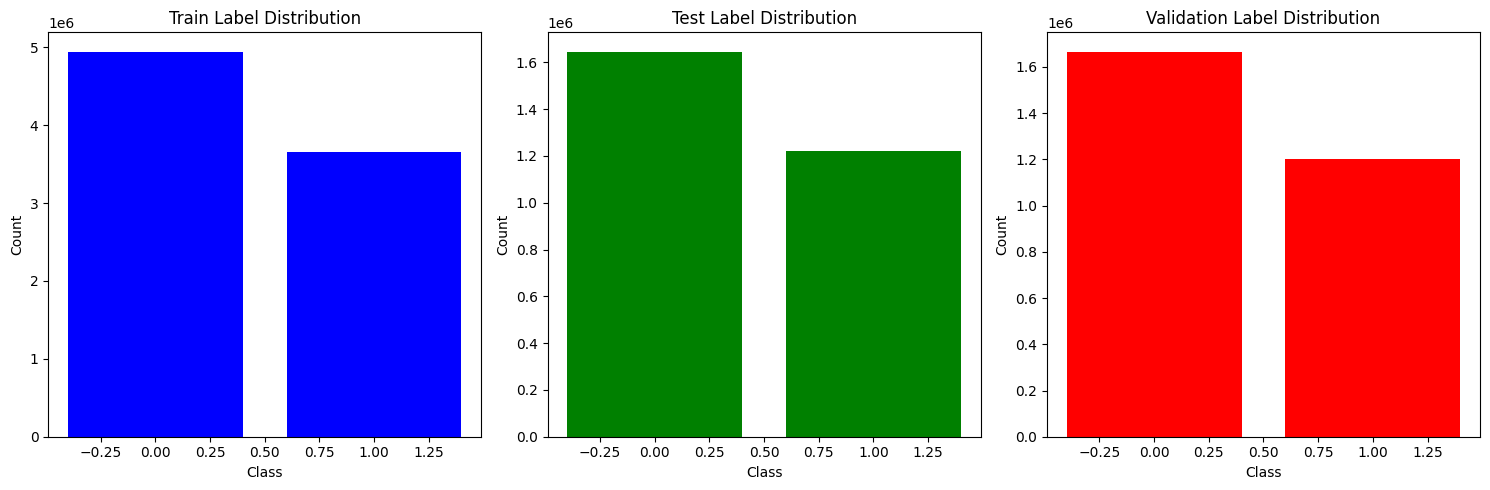

In [3]:


# Count unique classes and their occurrences for each dataset
unique_classes_train, counts_train = np.unique(train_label, return_counts=True)
unique_classes_test, counts_test = np.unique(test_label, return_counts=True)
unique_classes_val, counts_val = np.unique(val_label, return_counts=True)

# Create subplots for the three bar charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create bar charts for train_label
axs[0].bar(unique_classes_train, counts_train, color='b')
axs[0].set_title('Train Label Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')

# Create bar charts for test_label
axs[1].bar(unique_classes_test, counts_test, color='g')
axs[1].set_title('Test Label Distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

# Create bar charts for val_label
axs[2].bar(unique_classes_val, counts_val, color='r')
axs[2].set_title('Validation Label Distribution')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Count')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()
